In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import time

# Load Data

In [3]:
# Create plots directory if it doesn't exist
plots_dir = 'plots'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# Load Data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


In [8]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


# Build Vanilla and Convolutional Network

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size=512):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: 1 x 28 x 28
        self.features = nn.Sequential(
            # Conv1: Detects simple edges
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Downsample to 14x14
            
            # Conv2: Detects more complex shapes
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample to 7x7
        )
        
        # Classifier: Standard dense layers at the end
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512), # 64 channels * 7 * 7 spatial size
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        logits = self.classifier(x)
        return logits

# Training Loop

In [6]:
def train_and_evaluate(name, model, train_data, test_data, device):
    print(f"\n--- Training {name} ---")
    
    # Common hyperparameters
    batch_size = 64
    epochs = 10
    lr = 0.001
    
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = []
    start_time = time.time()
    
    for t in range(epochs):
        # Train Loop
        model.train()
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # Test Loop (Validation)
        model.eval()
        size = len(test_dataloader.dataset)
        num_batches = len(test_dataloader)
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        correct /= size
        history.append(correct)
        print(f"Epoch {t+1}/{epochs} - Accuracy: {correct:.4f}")

    print(f"Finished {name} in {time.time()-start_time:.2f}s")
    return history

In [9]:
results = {}

# 1. Train MLPNeuralNetwork
mlp_model = NeuralNetwork().to(device)
results['NeuralNetwork (Adam)'] = train_and_evaluate("NeuralNetwork", mlp_model, training_data, test_data, device)

# 2. Train CNN
cnn_model = CNN().to(device)
results['CNN (Adam)'] = train_and_evaluate("CNN", cnn_model, training_data, test_data, device)



--- Training NeuralNetwork ---
Epoch 1/10 - Accuracy: 0.8566
Epoch 2/10 - Accuracy: 0.8541
Epoch 3/10 - Accuracy: 0.8730
Epoch 4/10 - Accuracy: 0.8791
Epoch 5/10 - Accuracy: 0.8812
Epoch 6/10 - Accuracy: 0.8794
Epoch 7/10 - Accuracy: 0.8841
Epoch 8/10 - Accuracy: 0.8812
Epoch 9/10 - Accuracy: 0.8767
Epoch 10/10 - Accuracy: 0.8937
Finished NeuralNetwork in 50.62s

--- Training CNN ---
Epoch 1/10 - Accuracy: 0.8855
Epoch 2/10 - Accuracy: 0.9026
Epoch 3/10 - Accuracy: 0.9068
Epoch 4/10 - Accuracy: 0.9125
Epoch 5/10 - Accuracy: 0.9141
Epoch 6/10 - Accuracy: 0.9152
Epoch 7/10 - Accuracy: 0.9200
Epoch 8/10 - Accuracy: 0.9195
Epoch 9/10 - Accuracy: 0.9237
Epoch 10/10 - Accuracy: 0.9192
Finished CNN in 87.67s



Saved comparison plot to plots/cnn_vs_nn.png


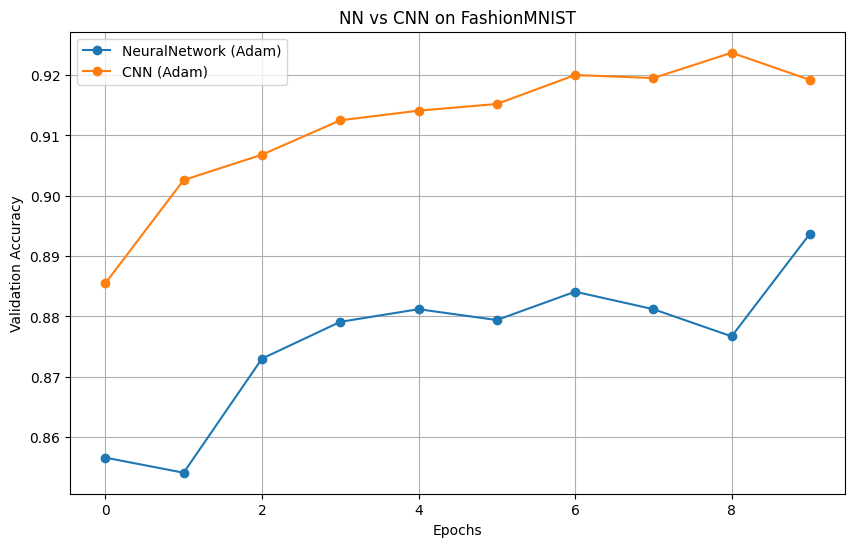

In [10]:
# 3. Plot Comparison
plt.figure(figsize=(10, 6))
for name, acc in results.items():
    plt.plot(acc, label=name, marker='o')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('NN vs CNN on FashionMNIST')
plt.legend()
plt.grid(True)
output_path = os.path.join(plots_dir, 'cnn_vs_nn.png')
plt.savefig(output_path)
print(f"\nSaved comparison plot to {output_path}")